In [1]:
%reload_ext jupyter_black
%reload_ext autoreload
%autoreload 2

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import json
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import sys

sys.path.insert(0, '..')
from util.train import train
from util.mlp_regressor import MLPRegressor

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data = {}

with open('data/train.json') as inp:
    data['train'] = json.load(inp)

with open('data/test.json') as inp:
    data['test'] = json.load(inp)

with open('data/train_random_crop_10_50.json') as inp:
    data['train_random_crop'] = json.load(inp)

with open('data/test_random_crop_10_50.json') as inp:
    data['test_random_crop'] = json.load(inp)

for dct in data.values():
    for key in dct:
        dct[key] = np.array(dct[key], dtype=np.float16)

In [ ]:
with open('data/train_random_crop_10_50.json') as inp:
    data['train_random_crop'] = json.load(inp)

for dct in data.values():
    for key in dct:
        dct[key] = np.array(dct[key], dtype=np.float16)

print('Half done')

Half done


In [49]:
with open('data/test_random_crop_10_50.json') as inp:
    data['test_random_crop'] = json.load(inp)

for dct in data.values():
    for key in dct:
        dct[key] = np.array(dct[key], dtype=np.float16)

In [50]:
for dct in data.values():
    dct['label'] = dct['label'].astype(np.int64)

In [ ]:
lr = LogisticRegression(verbose=True, max_iter=500, C=0.5)
lr.fit(data['train']['mean'], data['train']['label'])
y_test = lr.predict_proba(data['test']['mean'])
roc_auc_score(data['test']['label'], y_test[:, 1])  # type: ignore

/workspace/dl/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9820981440000001

In [ ]:
print('Accuracy:', (data['test']['label'] == (y_test[:, 1] > 0.5)).mean())

np.float64(0.9358)

In [61]:
lr = LogisticRegression(verbose=True, max_iter=500, C=0.5)
lr.fit(data['train']['max'], data['train']['label'])
y_test = lr.predict_proba(data['test']['max'])
print('Accuracy:', (data['test']['label'] == (y_test[:, 1] > 0.5)).mean())
print('Roc auc:', roc_auc_score(data['test']['label'], y_test[:, 1]))  # type: ignore

/workspace/dl/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8886
Roc auc: 0.957001696


In [73]:
def run_experiment(train_name: str, test_name: str, emb_method: str) -> pd.DataFrame:
    scaler = StandardScaler()
    X_train_np = scaler.fit_transform(data[train_name][emb_method])
    X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
    y_train = torch.tensor(data[train_name]['label'], dtype=torch.float32, device=device)

    val_idx = np.random.choice(len(data[test_name][emb_method]), size=5000, replace=False)
    X_val_np = scaler.transform(data[test_name][emb_method][val_idx])
    X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
    y_val = torch.tensor(data[test_name]['label'][val_idx], dtype=torch.float32, device=device)

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train),
        batch_size=32,
        shuffle=True,
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_val, y_val),
        batch_size=5000,
    )

    model = MLPRegressor(input_size=X_train.shape[1], hidden_size=10).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    criterion = nn.BCEWithLogitsLoss()

    df = train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=1,
        score_fns={
            'val_roc_auc': lambda y, p: roc_auc_score(y, p),
        },
        output_fn=torch.sigmoid,
    )
    df['train_name'] = train_name
    df['test_name'] = test_name
    df['emb_method'] = emb_method
    return df

In [74]:
results = []
for train_name, test_name in [
    ('train', 'test'),
    ('train_random_crop', 'test_random_crop'),
    ('train_random_crop', 'test'),
]:
    for emb_method in ['mean', 'min', 'max', 'first', 'last']:
        print(f'{train_name} / {test_name} / {emb_method}')
        results.append(run_experiment(train_name, test_name, emb_method))

all_metrics_df = pd.concat(results, ignore_index=True)
all_metrics_df

train / test / mean


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


train / test / min


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


train / test / max


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


train / test / first


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


train / test / last


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


train_random_crop / test_random_crop / mean


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


train_random_crop / test_random_crop / min


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


train_random_crop / test_random_crop / max


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


train_random_crop / test_random_crop / first


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


train_random_crop / test_random_crop / last


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


train_random_crop / test / mean


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


train_random_crop / test / min


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


train_random_crop / test / max


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


train_random_crop / test / first


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


train_random_crop / test / last


INFO:lightning_fabric.utilities.seed:Seed set to 42
100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


,epoch,train_loss,val_loss,val_roc_auc,train_name,test_name,emb_method
0,1,0.179675,0.157494,0.984753,train,test,mean
1,1,0.224982,0.192466,0.977488,train,test,min
2,1,0.219066,0.185151,0.978825,train,test,max
3,1,0.715129,0.692088,0.551624,train,test,first
4,1,0.159818,0.143723,0.987357,train,test,last
5,1,0.464497,0.441953,0.877713,train_random_crop,test_random_crop,mean
6,1,0.484349,0.449900,0.872198,train_random_crop,test_random_crop,min
7,1,0.485211,0.455123,0.868010,train_random_crop,test_random_crop,max
8,1,0.704938,0.695512,0.514401,train_random_crop,test_random_crop,first
9,1,0.440505,0.418457,0.889469,train_random_crop,test_random_crop,last


In [ ]:
print('Accuracy:', (data['test']['label'] == (y_test[:, 1] > 0.5)).mean())

np.float64(0.9358)

In [ ]:
print('Accuracy:', (data['test']['label'] == (y_test[:, 1] > 0.5)).mean())

np.float64(0.9358)

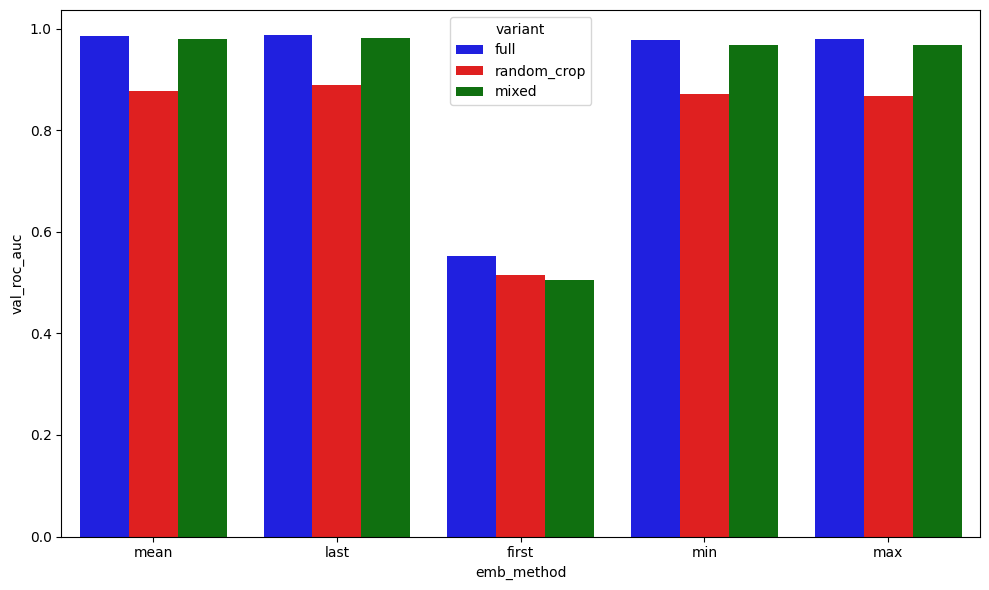

In [75]:
final_metrics = all_metrics_df.groupby(['train_name', 'test_name', 'emb_method']).last().reset_index()


def get_variant(row):
    if row['train_name'] == 'train':
        return 'full'
    elif row['test_name'] == 'test_random_crop':
        return 'random_crop'
    else:
        return 'mixed'


final_metrics['variant'] = final_metrics.apply(get_variant, axis=1)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=final_metrics,
    x='emb_method',
    y='val_roc_auc',
    hue='variant',
    palette={'full': 'blue', 'random_crop': 'red', 'mixed': 'green'},
    order=['mean', 'last', 'first', 'min', 'max'],
    hue_order=['full', 'random_crop', 'mixed'],
)
plt.xlabel('emb_method')
plt.ylabel('val_roc_auc')
plt.legend(title='variant')
plt.tight_layout()
plt.show()